In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import polyphase as phase
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.figure_factory as ff
%matplotlib notebook

In [3]:
htedf = pd.read_pickle('../data/htev2.pkl')
htedf.head()

,solvent,SM,polymer,chi12,chi13,chi23,dop,delta_solv,delta_SM,delta_polymer
0,Acetone,PC61BM,MDMO-PPV,0.440066,1.478520,1.90338,"[1626.0162601626018, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.62, 5.28]"
1,Acetone,PC61BM,MEH-PPV,0.458907,1.532581,1.90338,"[948.509485094851, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[19.06, 5.38, 5.44]"
2,Acetone,PC61BM,P3HT,0.630290,2.719685,1.90338,"[117.82726522917405, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.56, 2.88, 3.19]"
3,Acetone,PC61BM,PFO,0.660927,2.507620,1.90338,"[1200.4944610849618, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.55, 2.8, 4.51]"
4,Acetone,PC61BM,PM6,0.468860,1.896708,1.90338,"[1436.3143631436315, 12.410704607046071, 1]","[15.5, 10.4, 7.0]","[19.89, 5.68, 3.64]","[18.37, 4.36, 4.19]"


In [4]:
sys_ds = htedf[(htedf['solvent']=='Toluene')&(htedf['SM']=='DPP(TBFu)2')&(htedf['polymer']=='PFO')]
M = sys_ds['dop'].values[0]
chi = [sys_ds['chi12'].values[0], sys_ds['chi13'].values[0], sys_ds['chi23'].values[0]]
sys_ds

,solvent,SM,polymer,chi12,chi13,chi23,dop,delta_solv,delta_SM,delta_polymer
3543,Toluene,DPP(TBFu)2,PFO,0.664428,0.705938,1.679409,"[831.1115499818967, 7.101313320825517, 1]","[18.0, 1.4, 2.0]","[19.33, 4.78, 6.26]","[18.55, 2.8, 4.51]"


2020-10-15 22:37:09,705	INFO resource_spec.py:212 -- Starting Ray with 26.86 GiB memory available for workers and up to 13.43 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-15 22:37:09,946	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-10-15 22:37:10,495	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


3-dimensional grid generated at 0.07s
Using beta (=1.00E-04) correction for energy landscape
Energy computed at 0.31s
Energy is corrected at 0.31s
Convexhull is computed at 0.33s
Using 1.43E-01 as a threshold for Laplacian of a simplex
Total of 2598 simplices in the convex hull
Simplices are labelled at 4.45s
Labels are lifted at 5.84s
Total 11/2598 coplanar simplices
Computation took 5.87s


<IPython.core.display.Javascript object>


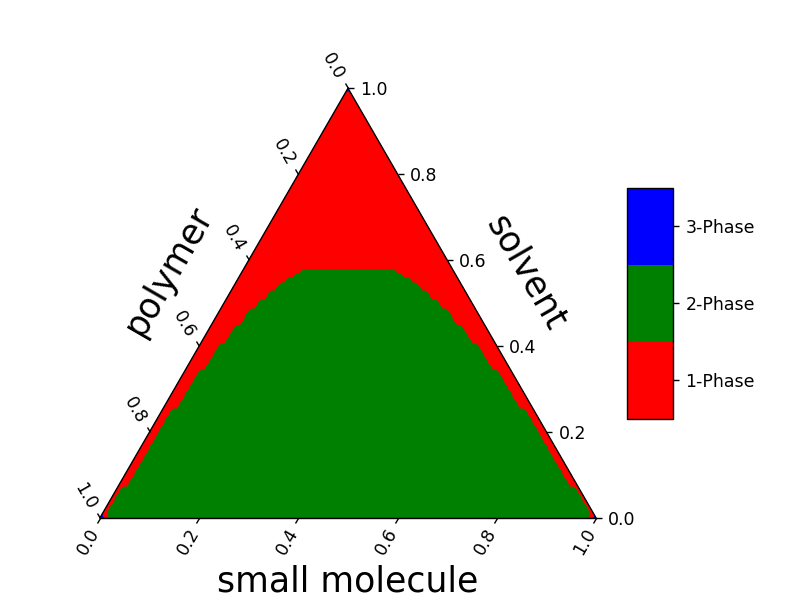

In [5]:
M = [5,5,1]
chi = [1, 0.5, 0.5]
#chi = [1, 0.5, 1]

configuration = {'M':M, 'chi':chi}

meshsize = 100
kwargs = {
    'flag_refine_simplices':True,
    'flag_lift_label': True,
    'use_weighted_delaunay': False,
    'flag_remove_collinear' : False, 
    'beta':1e-4, # not used 
    'flag_make_energy_paraboloid': False, 
    'pad_energy': 2,
    'flag_lift_purecomp_energy': False,
    'threshold_type':'uniform',
    'thresh_scale':0.1*meshsize,
    'lift_grid_size':meshsize,
    'verbose' : True
 }
out = phase.compute(configuration,meshsize, **kwargs) 
grid = out['grid']
num_comps = out['num_comps']
simplices = out['simplices']
energy = out['energy']

phase.plot_lifted_label_ternary(out['output'])
plt.show()

# 1. Visual tests

1. Plot convex hull and energy landscape

In [6]:
MIN_POINT_PRECISION = 1e-8
from collections import Counter

def is_boundary_point(point):
    if np.isclose(point, MIN_POINT_PRECISION).any():
        return True
    else:
        return False
    
def is_pure_component(point):
    counts = Counter(point)
    if counts[MIN_POINT_PRECISION]>1:
        return True
    else:
        return False
    
boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
pure_points = np.asarray([is_pure_component(x) for x in grid.T])

In [7]:
# Mesh size vs Energy surface
def makeAxis(title, tickangle):
    return {
      'title': title,
      'titlefont': { 'size': 20 },
      'tickangle': tickangle,
      'tickfont': { 'size': 15 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

def plotly_ternary_surface(grid, energy, num_comps):
    fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': "ternary"}, {'is_3d': True}]], 
                    subplot_titles=('Phase diagram','Energy landscape'),
                    print_grid=False)
    
    fig_00 = ff.create_ternary_contour(grid, num_comps,
                                    pole_labels=['polymer', 'SM', 'solvent'],
                                    interp_mode='cartesian',
                                    ncontours=3,
                                    coloring='lines')
    
    for i in fig_00.data:
        fig.append_trace(i, row=1, col=1)
        
    boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
    x, y, z = grid[0,~boundary_points], grid[1,~boundary_points], energy[~boundary_points]
    fig_01 = go.Mesh3d(x=x, y=y, z=z, color='blue')
    fig.append_trace(fig_01,row=1, col=2)
    fig.update_layout(scene1 = dict(xaxis_title='polymer',yaxis_title='SM',zaxis_title='Energy',aspectmode='cube'))

    fig.update_layout(template='plotly_white')
    #fig.update_layout(showlegend=False)
    fig.update_layout({'ternary': {'sum': 100,
                                   'aaxis': makeAxis('Polymer', 0),
                                   'baxis': makeAxis('<br>Small Molecule', 45),
                                   'caxis': makeAxis('<br>Solvent', -45)}
                      })
    fig.layout.annotations[0].update(x=0.025)
    fig.layout.annotations[1].update(x=0.65)
    
    return fig


def plt_ternary_surface(grid, energy, num_comps):
    fig = plt.figure(figsize=(3*4*1.6,4))
    ax1 = fig.add_subplot(1,3,2, projection='3d')
    ax1.plot_trisurf(grid[0,:], grid[1,:], energy, linewidth=0.01, antialiased=True)
    ax1.set_xlabel('Polymer')
    ax1.set_ylabel('Small molecule')
    ax1.set_zlabel('Energy')
    ax1.set_title('Energy landscape', pad=42)
    
    ax2 = fig.add_subplot(1, 3, 1, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], energy)
    ax2.set_title("Energy contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    ax2 = fig.add_subplot(1, 3, 3, projection='ternary')
    cs = ax2.tricontour(grid[0,:], grid[1,:], grid[2,:], num_comps)
    ax2.set_title("Phase contours", pad=42)
    ax2.clabel(cs)
    ax2.set_tlabel('Polymer')
    ax2.set_llabel('Small molecule')
    ax2.set_rlabel('Solvent')

    ax2.taxis.set_label_position('tick1')
    ax2.laxis.set_label_position('tick1')
    ax2.raxis.set_label_position('tick1')
    
    plt.tight_layout()
    return

labels = out['output'].loc['label',:].to_numpy()
boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
plt_ternary_surface(grid[:,~boundary_points], energy[~boundary_points], labels[~boundary_points])
#plt.savefig('../figures/notebooks/{}.png'.format(m), dpi=500, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>

# Centroid tests

For 3-phase simplices, energy at the centroid should be lesser than that of the vertices

In [8]:
X = out['output']
CHI = phase._utri2mat(chi, len(M))
phase3 = np.asarray(simplices)[np.asarray(num_comps)==2]
ind = np.random.randint(len(phase3))
print(ind)

83


# 3. Common tangent test
There's a chance that this would not work because of [sub-derivative of a convex functions](https://en.wikipedia.org/wiki/Subderivative). So not being able to match the local derivatives at any tangent plane is fine because you're working with a discrete surface approximation of the energy landscape.

In [9]:
X = out['output']
phase3 = np.asarray(simplices)[np.asarray(num_comps)==2]
ind = np.random.randint(len(phase3))
print(ind)

20


In [10]:
def threecomp_gradphi(x, beta=0):
    dEdx1 = (1/M[0])*(1+np.log(x[0])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] +\
    CHI[0,2] - 2*CHI[0,2]*x[0] - CHI[0,2]*x[1] - CHI[1,2]*x[1] + beta*((1/x[2]**2) - (1/x[0]**2))
    
    dEdx2 = (1/M[1])*(1+np.log(x[1])) - (1/M[2])*(1+np.log(x[2])) + CHI[0,1]*x[0] -\
    CHI[0,2]*x[0] + CHI[1,2] - 2*CHI[1,2]*x[1]  - CHI[1,2]*x[0]+ beta*((1/x[2]**2) - (1/x[1]**2))
    
    return [dEdx1, dEdx2]

vertices = X.iloc[:3,phase3[ind]].to_numpy().T
points = np.hstack((vertices[:,:2], energy[phase3[ind]].reshape(-1,1))).tolist()
grads = []
for v in vertices:
    print(v, np.sum(v))
    grads.append(threecomp_gradphi(v, beta=1e-4))

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='ternary')
for i, (g,v) in enumerate(zip(grads, vertices)):
    magnitude = np.linalg.norm(g)
    unitvec = g/magnitude
    angle = np.degrees(np.arccos(np.clip(np.dot(np.array([1,0]), unitvec), -1.0, 1.0)))

    print(i, 'Magnitude : {:.2f}'.format(magnitude), 'angle : {:.2f}'.format(angle))
    ax1.quiver(0,0,1,0,angles='xy', scale_units='xy',scale=1, ls='--', lw=2.0, color='tab:red')
    ax1.quiver(0, 0, unitvec[0], unitvec[1], angles='xy', scale_units='xy', scale=1)
    ax1.text(unitvec[0], unitvec[1], str(i))
    ax2.scatter(v[0], v[1], v[2], color='k')
    ax2.text(v[0], v[1], v[2], str(i))

    
ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_xlabel(r'$\frac{\delta E}{\delta\phi_1}$')
ax1.set_ylabel(r'$\frac{\delta E}{\delta\phi_2}$')

ax2.set_tlabel('Polymer')
ax2.set_llabel('Small molecule')
ax2.set_rlabel('Solvent')

ax2.taxis.set_label_position('tick1')
ax2.laxis.set_label_position('tick1')
ax2.raxis.set_label_position('tick1')
plt.show()

[0.06060607 0.51515152 0.42424243] 1.0000000199999999
[0.51515152 0.06060607 0.42424243] 1.0000000199999999
[0.52525253 0.06060607 0.41414142] 1.0000000199999999


<IPython.core.display.Javascript object>

0 Magnitude : 0.55 angle : 170.61
1 Magnitude : 0.38 angle : 13.95
2 Magnitude : 0.40 angle : 9.60


<IPython.core.display.Javascript object>


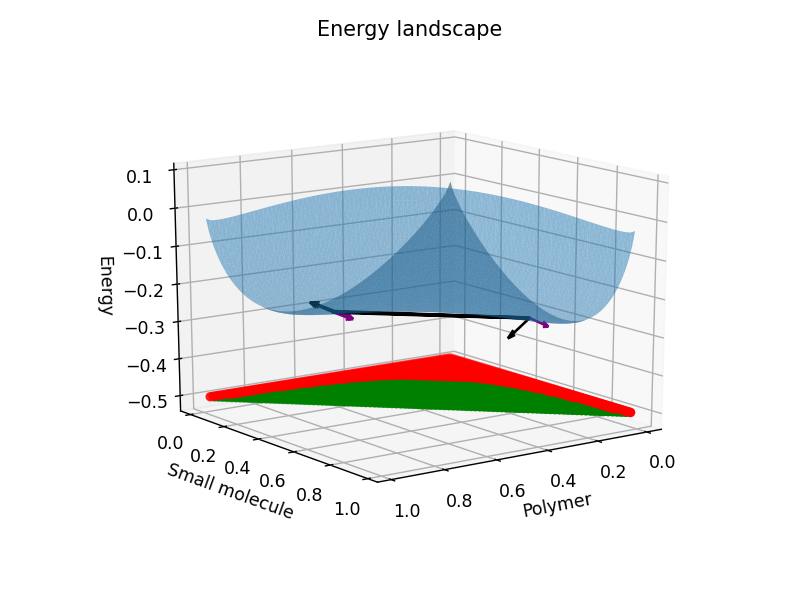

In [29]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import ScalarMappable
from matplotlib import colors

vertices = X.iloc[:3,phase3[ind]].to_numpy().T
fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
boundary_points= np.asarray([is_boundary_point(x) for x in grid.T])
ps = ax.plot_trisurf(grid[0,~boundary_points], grid[1,~boundary_points], energy[~boundary_points],
                     linewidth=0.01, antialiased=True)
verts = np.hstack((vertices[:,:2], energy[phase3[ind]].reshape(-1,1)))
poly = Poly3DCollection(verts,  alpha=1.0, lw=2.0, facecolors=['tab:red'], edgecolors=['k'])
ax.add_collection3d(poly)
labels = out['output'].loc['label',:].to_numpy()
phase_colors =['r','g','b']

for i, (v,e) in enumerate(zip(vertices,energy[phase3[ind]])):
    dx,dy = threecomp_gradphi(v)
    ru = [1,0,dx]
    rv = [0,1,dy]
    uru = ru/np.linalg.norm(ru)
    urv = rv/np.linalg.norm(rv)
    ax.quiver(v[0], v[1], e, uru[0],uru[1],uru[2], length=0.1, normalize=True, color='k')
    ax.quiver(v[0], v[1], e, urv[0],urv[1],urv[2], length=0.1, normalize=True, color='purple')
    
for i in [1,2,3]:
    criteria = np.logical_and(labels==i, ~boundary_points)
    ax.scatter(grid[0,criteria], grid[1,criteria], zs=-0.5, zdir='z',
               c=phase_colors[int(i-1)])

ps.set_alpha(0.5)
ax.set_xlabel('Polymer')
ax.set_ylabel('Small molecule')
ax.set_zlabel('Energy')
ax.set_title('Energy landscape', pad=42)
ax.view_init(elev=16, azim=54)

plt.show()

<IPython.core.display.Javascript object>


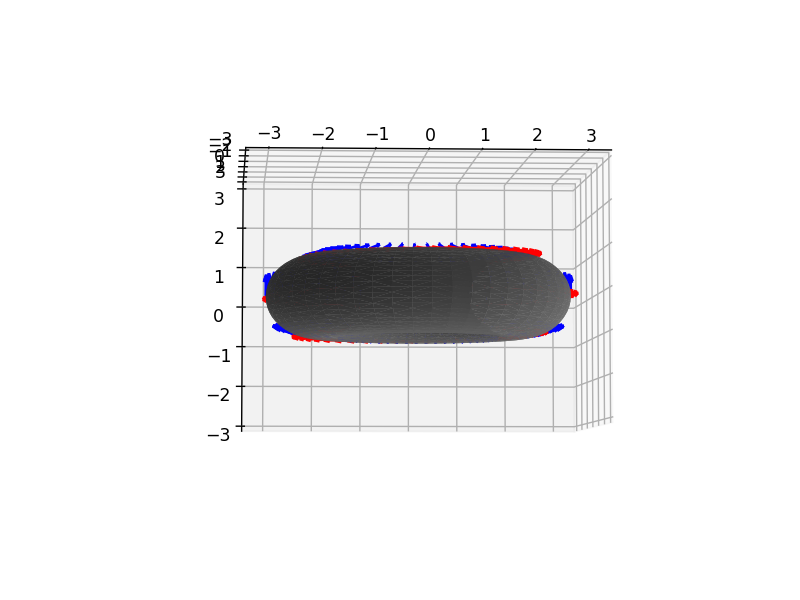

In [77]:
# vector field on a torus
import matplotlib.tri as mtri

n = 50
_theta = np.linspace(0, 2.*np.pi, n)
_phi = np.linspace(0, 2.*np.pi, n)
_theta, _phi = np.meshgrid(_theta, _phi)
positions = np.vstack([_theta.ravel(), _phi.ravel()]).T

def get_trous_pointcloud(theta, phi):

    c, a = 2, 1
    x = (c + a*np.cos(theta)) * np.cos(phi)
    y = (c + a*np.cos(theta)) * np.sin(phi)
    z = a * np.sin(theta)
    
    return [x,y,z]

def get_trous_gradients(theta, phi):

    rtheta = [-a*np.cos(phi)*np.sin(theta), -a*np.sin(phi)*np.sin(theta), a*np.cos(theta)]
    rphi = [-np.sin(phi)*(c + a*np.cos(theta)), -np.cos(phi)*(c + a*np.cos(theta)), 0]

    uv_rtheta = rtheta/np.linalg.norm(rtheta)
    uv_rphi = rphi/np.linalg.norm(rphi)
    
    return uv_rtheta, uv_rphi

tri = mtri.Triangulation(positions[:,0], positions[:,1])
T = np.asarray([get_trous_pointcloud(u,v) for u,v in positions])
#Ru, Rv = np.asarray([get_trous_gradients(u,v) for u,v in positions])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(T[:,0], T[:,1], T[:,2],triangles=tri.triangles,linewidth=0.01, color='gray')

for i in range(0, len(positions),10):
    x,y,z = T[i,:]
    RU, RV = get_trous_gradients(positions[i,0], positions[i,1])
    ax.quiver(x,y,z, RU[0], RU[1], RU[2],length=0.5, normalize=True, color='b' )
    ax.quiver(x,y,z, RV[0], RV[1], RV[2],length=0.5, normalize=True, color='r' )

ax.set_zlim([-3,3])
plt.show()

In [12]:
# compute tangent equation
from sympy import Plane, Point3D, Line3D
import pdb

def simplify(expr):
    eq_str = []
    for key, value in expr.as_coefficients_dict().items():
        coeff = float(value)
        varname = str(key)
        if coeff>0:
            eq_str.append('+{:.2E}*{}'.format(coeff, varname))
        else:
            eq_str.append('{:.2E}*{}'.format(coeff, varname))
            
    return ' '.join(i for i in eq_str)

points = np.hstack((vertices[:,:2], energy[phase3[ind]].reshape(-1,1))).tolist()
plane_points = Plane(points[0], points[1], points[2])
print('Equation of plane through points : {}'.format(simplify(plane_points.equation())))

point_normal_planes = []
for i, (v,e) in enumerate(zip(vertices,energy[phase3[ind]])):
    x1,x2,_ = v
    p = Point3D(x1, x2, e)
    dx,dy = threecomp_gradphi(v)
    magnitude = np.linalg.norm([dx,dy,1])
    n1,n2,n3 = np.array([dx,dy,1])/magnitude
    
    tangent_line = Line3D(p, direction_ratio=[n1,n2,n3])
    tangent_normal = tangent_line.perpendicular_line(p)
    
    point_normal_planes.append(Plane(p, normal_vector = tangent_normal.direction))
    msg = 'Equation of plane through point {} with dE/dx={:.2f} and dE/dy={:.2f} is:\n{}'
    print(msg.format(i,n1,n2,simplify(point_normal_planes[-1].equation())))
    
    print(plane_points.equals(point_normal_planes[-1]))


Equation of plane through points : +1.21E-03*1 +4.59E-03*z +3.73E-04*x +3.73E-04*y
Equation of plane through point 0 with dE/dx=-0.46 and dE/dy=-0.08 is:
-2.31E-01*1 -8.00E-02*x +4.59E-01*y
False
Equation of plane through point 1 with dE/dx=0.34 and dE/dy=-0.06 is:
+5.15E-02*1 -5.99E-02*x -3.42E-01*y
False
Equation of plane through point 2 with dE/dx=0.36 and dE/dy=-0.04 is:
+4.15E-02*1 -3.70E-02*x -3.65E-01*y
False


<IPython.core.display.Javascript object>


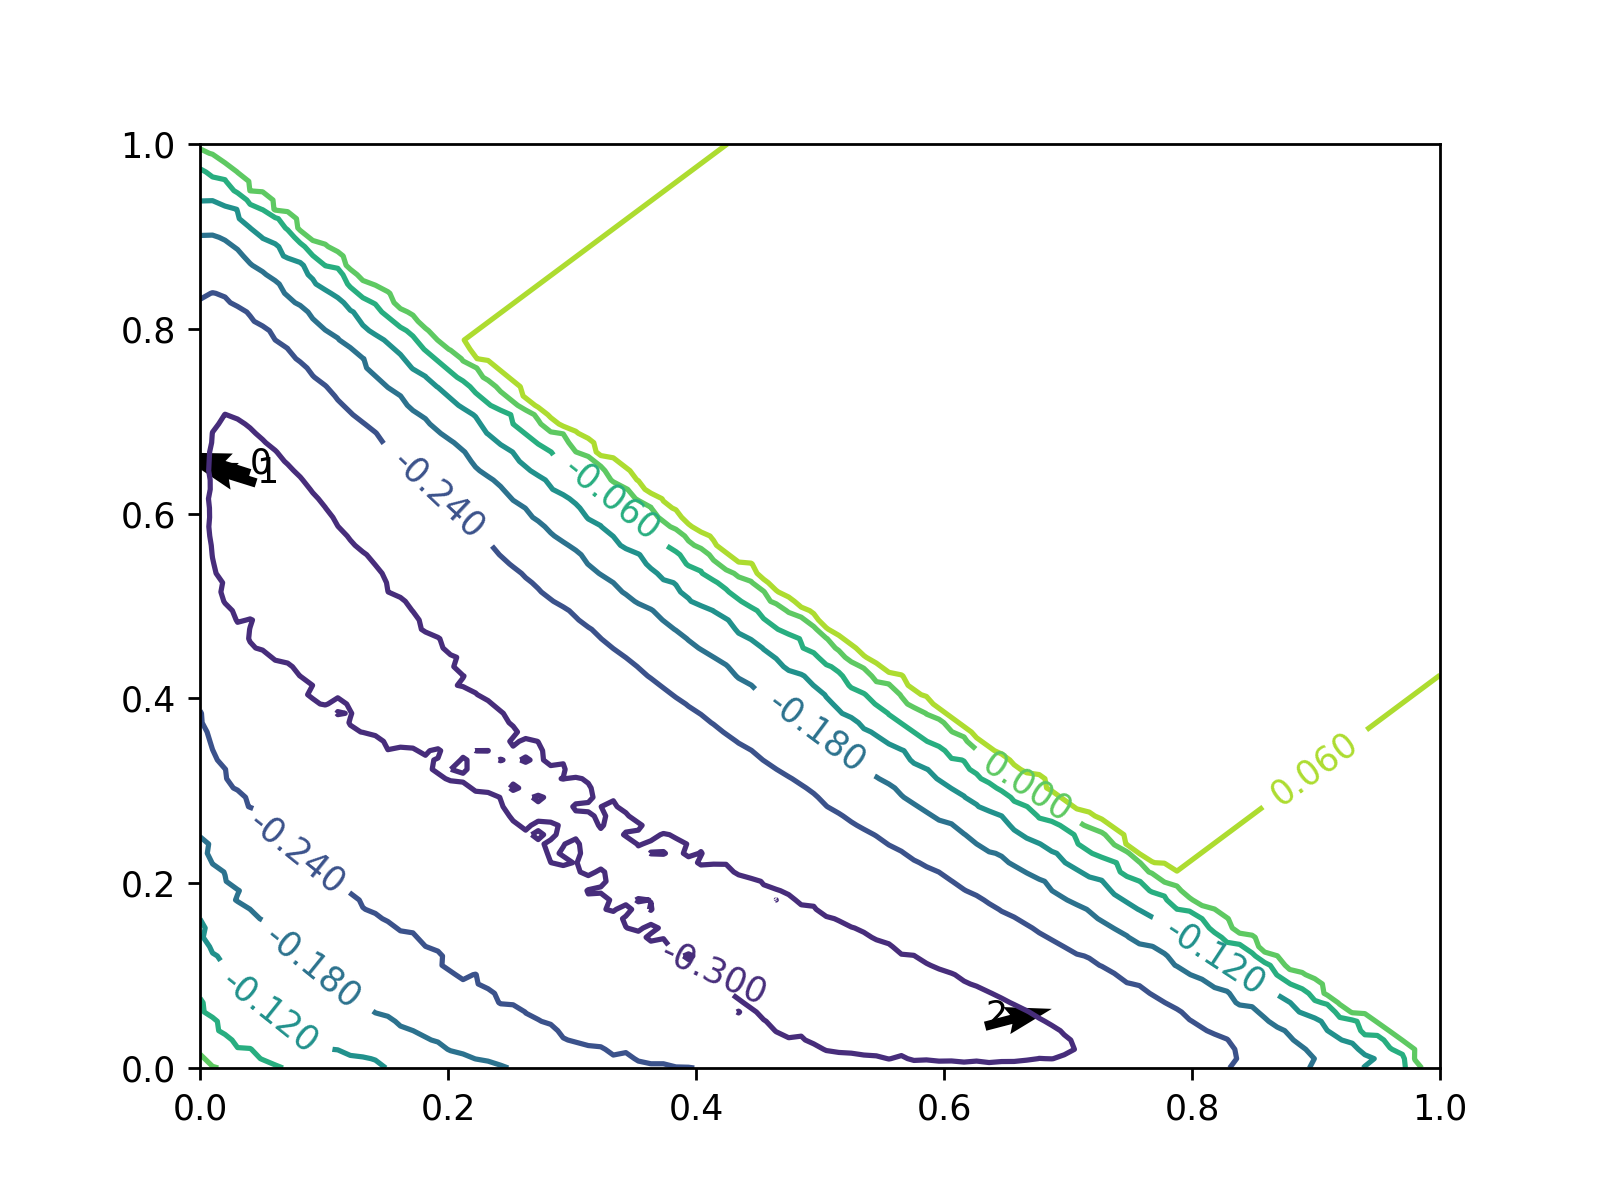

In [13]:
from scipy.interpolate import griddata
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
points = grid[:2,~boundary_points]
grid_z0 = griddata(points.T, energy[~boundary_points], (grid_x, grid_y), method='nearest')

fig, ax = plt.subplots()
CS = ax.contour(grid_x, grid_y, grid_z0)
ax.clabel(CS, inline=True, fontsize=10)
for i, (g,v) in enumerate(zip(grads, vertices)):
    unitvec = g/np.linalg.norm(g)
    ax.quiver(v[0], v[1], unitvec[0], unitvec[1])
    ax.text(v[0], v[1], str(i))
    
plt.show()

In [30]:
# number of simplices
from scipy.spatial import Delaunay
points = X.loc[['Phi_1','Phi_2'],:].to_numpy().T
tri = Delaunay(points)
print('Total of {} simplices in delaunay triangulation of original energy landscape'.format(len(tri.simplices)))

(225743, 2)
Total of 90593 simplices in delaunay triangulation of original energy landscape


In [57]:
QR = vertices[0] - vertices[1]
QS = vertices[0] - vertices[2]
normal = np.cross(QR, QS)
normal/np.linalg.norm(normal)

array([0.57735027, 0.57735027, 0.57735027])

import autograd.numpy as anp
from autograd import grad
import pdb
from itertools import combinations

chi = [3]
M = [1,1]
CHI = phase._utri2mat(chi, len(M))
combs = combinations(anp.arange(len(M)),2)
pairs = [c for c in combs]

def flory_huggins(x):
    T1 = 0
    T2 = 0
    x = anp.asarray(x)
    xend = 1-anp.sum(x[:-1])
    
    for i,xi in enumerate(x):
        T1 = T1+ (xi*anp.log(xi))/M[i]

    for i,j in pairs:
        T2 = T2+ CHI[i,j]*x[i]*x[j] 
        
    return T1+T2  

def twocomp_energy(x):
    return x*(np.log(x)) + (1-x)*np.log(1-x) + chi[0]*x*(1-x)

def twocomp_gradphi(x):
    return np.log(x/(1-x))+chi[0]*(1-2*x)

phi = 0.5

energy_result = flory_huggins([phi, 1-phi])
energy_expected = twocomp_energy(phi)
assert np.isclose(energy_result, energy_expected), 'Expected {:.2f} got {:.2f}'.format(energy_expected, energy_result)

grad_FH = grad(flory_huggins)
grad_result = grad_FH([phi, 1-phi])[0]
grad_expected = twocomp_gradphi(phi)
assert np.isclose(grad_result, grad_expected), 'Expected {:.2f} got {:.2f}'.format(grad_expected, grad_result)